# Machine Learning to Find Fake Amazon Reviews

Springboard Data Science Career Track
Capstone 2
by Chantel Clark

### About
In this notebook, I create a machine learning model that finds patterns in customer behavior and the text of customer reviews to identify suspicious reviews. In order to find patterns in the text reviews, Natural Language Processing was used to process the text reviews with TF-IDF (term frequency - inverse document frequency) vectorization. No labels to identify fake reviews were available in the original dataset, so I created the target labels to enable supervised learning. The models tested include Multinomial Naive Bayes, Random Forest, and Linear SVC with various combinations of text, numerical and categorical features.

### Data
This project uses Amazon's open dataset of over 130 million customer reviews collected between 1995 and 2015, available at https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt. Reviews are grouped by product categories such as apparel, automotive, books, e-books, etc. The columns in the dataset include: ‘marketplace’ (country code), ‘customer_id’, ‘review_id’, ‘product_id’, ‘product_parent’ (random identifier for aggregate reviews for the same product), ‘product_title’, ‘product_category’, ‘star_rating’, ‘helpful_votes’, ‘total_votes’, ‘vine’, ‘verified_purchase’, ‘review_headline’, ‘review_body’, ‘review_date’.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import nltk
from nltk import word_tokenize 
from nltk.corpus import stopwords
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
#nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import fbeta_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
from yellowbrick.text.tsne import tsne

import time
import re
import random
import pickle
import emoji
from wordcloud import WordCloud

C:\Users\chant\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# Pandas option - show entire review
pd.set_option('display.max_colwidth', None)

In [3]:
# Import list of customer id's of suspects (those who write more than 30 or more reviews within a day)
with open('suspects.pkl', 'rb') as f:
    suspects30 = pickle.load(f)

In [4]:
%%time
# Import Amazon apparel reviews
# Skips 'bad_lines', gets tokenization error without skipping (C error: expected 15 fields, saw 22)
url = 'https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz'
url_data = pd.read_table(url, sep='\t', error_bad_lines=False)
url_df = pd.DataFrame(url_data, columns=url_data.keys())
print(url_df.head())

b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fields, saw 22\nSkipping line 326099: expected 15 fields, saw 22\nSkipping line 327595: expected 15 fields, saw 22\n'
b'Skipping line 342645: expected 15 fields, saw 22\nSkipping line 347980: expected 15 fields, saw 22\nSkipping line 376258: expected 15 fields, saw 22\nSkipping line 381192: expected 

  marketplace  customer_id       review_id  product_id  product_parent  \
0          US     32158956  R1KKOXHNI8MSXU  B01KL6O72Y        24485154   
1          US      2714559  R26SP2OPDK4HT7  B01ID3ZS5W       363128556   
2          US     12608825   RWQEDYAX373I1  B01I497BGY       811958549   
3          US     25482800  R231YI7R4GPF6J  B01HDXFZK6       692205728   
4          US      9310286  R3KO3W45DD0L1K  B01G6MBEBY       431150422   

                                                                          product_title  \
0  Easy Tool Stainless Steel Fruit Pineapple Corer Slicer Peeler Cut (One size, sliver)   
1    V28 Women Cowl Neck Knit Stretchable Elasticity Long Sleeve Slim Fit Sweater Dress   
2                              James Fiallo Men's 12-Pairs Low Cut Athletic Sport Socks   
3          Belfry Gangster 100% Wool Stain-Resistant Crushable Dress Fedora in 4 Colors   
4          JAEDEN Women's Beaded Spaghetti Straps Sexy Long Formal Prom Evening Dresses   

  produc

In [5]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881874 entries, 0 to 5881873
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 673.1+ MB


There are 5,881,873 reviews in this dataset.

In [6]:
# Convert 'review_date' column to datetime
url_df['review_date'] = pd.to_datetime(url_df['review_date'])

In [7]:
stopwords_english = stopwords.words('english')

# Add stop words
add_to_stopwords = ['ha', 'le', 'u', 'wa', "'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would']
for i in add_to_stopwords:
    stopwords_english.append(i)
    
print(stopwords_english[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [8]:
class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [9]:
lemmatizer = WordNetLemmatizer()

# Function to tokenize and stem, citation: 
# adapted from http://brandonrose.org/clustering on April 10, 2020
def tokenize_lem(text):
    # Tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # Filter tokens not containing letters
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemmas = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lemmas

### Labelling targets

In [10]:
# List of suspects with 30 or more reviews written in a day
suspects30[:10]

[50612720,
 33883540,
 33924372,
 32254988,
 12919673,
 14230771,
 19672530,
 37965911,
 11232231,
 27589096]

In [11]:
# Create boolean 'suspect' column
url_df['suspect'] = 0

# Create non_suspect, copy of url_df
non_suspect = url_df.copy()

In [12]:
%%time
# Create a dataframe of just the suspects (suspects_df) and a dataframe of non-suspects (non_suspect)
suspects_df = pd.DataFrame(columns = url_df.columns)
for cid in suspects30:
    boolean = url_df.customer_id == cid
    # Set suspect = 1 in url_df
    url_df['suspect'].loc[boolean] = 1
    
    temp = url_df[boolean]
    # drop the suspects from non_suspect df
    non_suspect.drop(temp.index, inplace=True)
    # append temp to suspects_df
    suspects_df = pd.concat([suspects_df, temp], ignore_index=True)

C:\Users\chant\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Wall time: 6min 11s


In [13]:
# Number of reviews from non_suspect
len(non_suspect)

5866513

In [14]:
# How many reviews do not have a review_body?
print(len(non_suspect[non_suspect.review_body.isnull()]), 'from non_suspect')
print(len(suspects_df[suspects_df.review_body.isnull()]), 'from suspects_df')

784 from non_suspect
1 from suspects_df


### Cosine similarity for the reviews of most active user

In [15]:
# Get reviews and info of most active suspect (with > 500 reviews)
suspects_df[suspects_df.customer_id == 50612720]

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,suspect
0,US,50612720,RHNSTL5UZQQTS,B002TPMFL6,15026908,Tunic Top Cotton Kurti-brown Gold Printed Cotton Kurta with Nice Embroidery Small Size,Apparel,4.0,0.0,0.0,N,N,women tunic top,Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.,2009-10-23,1
1,US,50612720,R2R5WABNC8M64U,B002ON2DB0,744097385,Fashion Blue Skirt Floral Print Fashion Clothes of India Size 36 Inches,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11,1
2,US,50612720,R2W6U4GDW9Y6GN,B002ON09KC,34396106,Skirts for Women Barmer Print Spring and Summer Fashion Clothes of India Size 36 Inches,Apparel,4.0,0.0,0.0,N,N,casual summer Spring womens Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This crinkle skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11,1
3,US,50612720,R3NF2BJCZ5BMIX,B002ON07NG,127355835,Designer Skirt Floral Print Spring and Summer Fashion Clothes of India Size 36 Inches,Apparel,5.0,0.0,0.0,N,N,Casual Summer Spring Women's Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This printed skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11,1
4,US,50612720,RO2B3TWOH87H6,B002OMYEWW,140362456,Skirts for Girl Ethnic Print Spring and Summer Fashion Clothes of India Size 36 Inches,Apparel,5.0,0.0,0.0,N,N,casual summer Spring womens Skirt,"This classic cotton boho tier skirt are perfect for all long and short kurtis. A fun & fashionable skirt by Mogul Interior! This ethnic skirt offers a bohemian style and tie design Skirt is stylish, easy to wear, and is one of this season's hottest looks! Cotton.",2009-09-11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554,US,50612720,R18I1FOID2QO18,B002239JNC,706063717,Designer White Cotton Embrdy Kurta Shirt Kurti Blouse L,Apparel,5.0,0.0,0.0,N,N,summer dress chikan embroidery womens top,"This pretty floral embroidered defines your diva status. Allover embroidered tunic with a solid round neckline, full sleeves, and design in the front and the same design runs straight in both side of the sleeves to give it a finished look.",2009-07-23,1
555,US,50612720,R15MC60QOBSOKX,B00222U6W6,995773338,India Red Gray Crepe Print Kurta Shirt Kurti Blouse Yoga M,Apparel,4.0,0.0,0.0,N,N,printed Cotton Kurti,"This pretty floral print defines your diva status. Allover print tunic with a solid round neckline, full sleeves, and designer print in the front and the same design runs straight in both side of the sleeves to give it a finished look.",2009-07-21,1
556,US,50612720,RUQI3Y8DDTNGQ,B00222RMOQ,45546345,India Blue Gold Crepe Print Kurta Shirt Kurti Blouse Yoga M,Apparel,5.0,0.0,0.0,N,N,printed crepe Kurti,"This pretty floral print defines your diva status. Allover print tunic with a solid round neckline, full sleeves, and designer print in the front and the same design runs straight in both side of the sleeves to give it a finished look.",2009-07-21,1
557,US,50612720,R5EFXUX49APD4,B00222GBDE,682508912,India Ivory Purple Crepe Print Kurta Shirt Kurti Blouse Yoga M,Apparel,4.0,0.0,0.0,N,N,printed crepe Kurti,"This pretty floral print defines your diva status. Allover print tunic with a solid round neckline, full sleeves, and designer print in the front and th

In [16]:
# Instantiate tfidf vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_english, tokenizer=tokenize_lem)
temp_revs = suspects_df[suspects_df.customer_id == 50612720].review_body
matrix = tfidf.fit_transform(temp_revs)
matrix.shape

(559, 220)

In [17]:
# Vocabulary from all of the user's reviews
tfidf.get_feature_names()

['-summer',
 '3/4th',
 'absorbing',
 'accessory',
 'add',
 'adjustable',
 'allover',
 'along',
 'amazing',
 'around',
 'art',
 'available',
 'batik',
 'bead',
 'beaded',
 'beautiful',
 'beauty',
 'blend',
 'blouse',
 'bohemian',
 'boho',
 'bollywood',
 'br',
 'bra',
 'browse',
 'buy',
 'captured',
 'casual',
 'chiffon',
 'chikan',
 'choli',
 'classic',
 'coin',
 'collection',
 'color',
 'colored',
 'combination',
 'comfortable',
 'cool',
 'cotton',
 'couple',
 'create',
 'created',
 'crepe',
 'crinkle',
 'culture',
 'day',
 'defines',
 'design',
 'designer',
 'different',
 'diva',
 'dress',
 'durable',
 'dyed',
 'e.g',
 'easy',
 'effect',
 'elastic',
 'embroidered',
 'embroidery',
 'etc',
 'etc.and',
 'etc.the',
 'ethnic',
 'exotic',
 'extensively',
 'extremely',
 'eye-catching',
 'fabric',
 'fabric.cotton',
 'fashion',
 'fashionable',
 'featuring',
 'festival',
 'finest',
 'finished',
 'fit',
 'floral',
 'flying',
 'formal',
 'front',
 'full',
 'fun',
 'georgette',
 'give',
 'gorgeous

In [18]:
# Create cosine similarity matrix
cosine_matrix = cosine_similarity(matrix, matrix)

In [19]:
print(cosine_matrix.shape)
#type(cosine_matrix)

(559, 559)


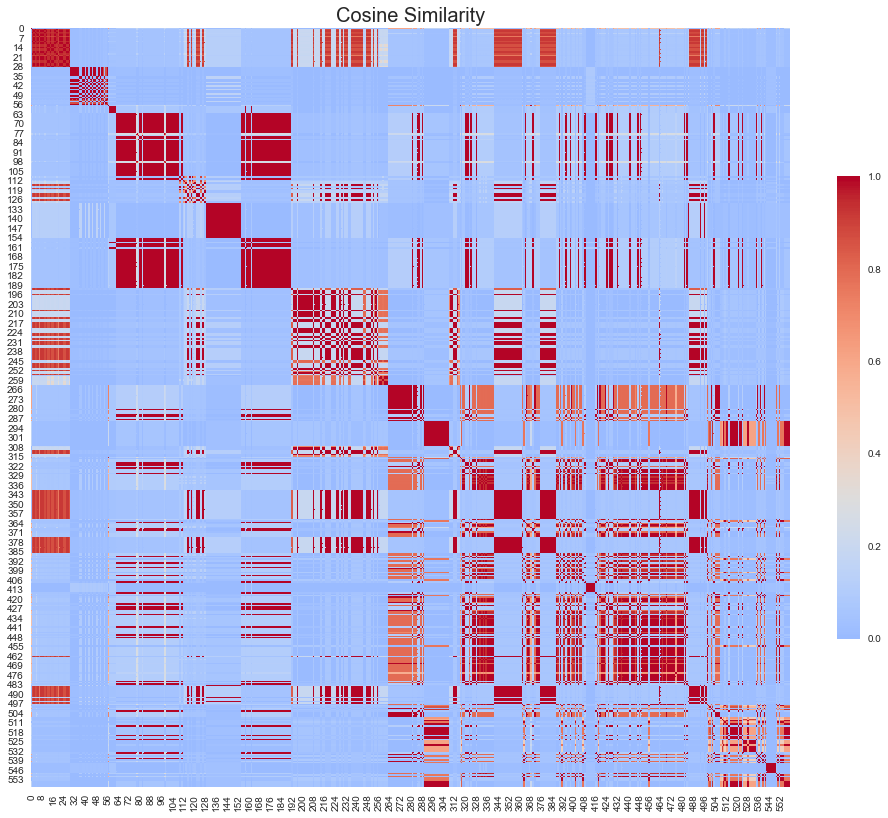

In [20]:
def get_heatmap(matrix):
    plt.figure(figsize=(17,17))
    ax = sns.heatmap(
        matrix, 
        vmin=0.0, vmax=1, center=0.3,
        cmap='coolwarm',
        square=True,
        robust=True,
        annot_kws={"size":10},
        cbar_kws={"shrink": 0.5}
    )
    plt.title('Cosine Similarity', fontsize=20)
    
get_heatmap(cosine_matrix)

In [21]:
def get_similar_revs(index, n):
    """ Find the n most similar reviews to review with given index"""
    test_ind = index
    print('Test index:', test_ind)
    test = cosine_matrix[test_ind]
    # Indices
    temp = np.argpartition(-test, range(n+1))
    result_args = temp[1:n+1]
    print('Indices:', result_args) # indices of highest values
    # Cosine similarity
    temp = np.partition(-test, range(n+1))
    result = -temp[1:n+1]
    print('Cosine similarity:', result) # highest values
    print()
    #return result

    # Print out test review, and most similar reviews
    print('Reviews similar to:', temp_revs[test_ind])
    print()
    for ind in result_args:
        if ind != test_ind:
            print('Review', ind, ':', temp_revs[ind])
            
    return result


In [22]:
results = get_similar_revs(0, 5)

Test index: 0
Indices: [316 368  57 263 264]
Cosine similarity: [0.69284376 0.65421925 0.63934845 0.60677216 0.60677216]

Reviews similar to: Stunning Cotton Kurti with gorgeous colored print. This ethnic kurti is master piece of Indian Ethnic Art.

Review 316 : Stunning Cotton Kurti with gorgeous printed. This ethnic print kurti is master piece of indian Ethnic Art. Must have collection for party wear.
Review 368 : Stunning Cotton tunic with gorgeous print. This ethnic printed kurti is master piece of Indian Ethnic Art. Must have collection for party wear.
Review 57 : Stunning tunic with gorgeous print. This ethnic printed kurti is master piece of Indian Ethnic Art. Must have collection for party wear.
Review 263 : Stunning Cotton Kurti with gorgeous embroidery. This ethnic embroidery kurti is master piece of Indian Ethnic Art. Must have collection for party wear.
Review 264 : Stunning Cotton Kurti with gorgeous embroidery. This ethnic embroidery kurti is master piece of Indian Ethnic

In [23]:
# Drop null reviews, create Series of reviews
non_suspect_revs = non_suspect.review_body.dropna(axis=0)
suspect_revs = suspects_df.review_body.dropna(axis=0)

In [24]:
print('Total number of non-suspect reviews: {}'.format(len(non_suspect_revs)))
print('Total number of suspect reviews: {}'.format(len(suspect_revs)))
print('Total number of reviews: {}'.format(len(non_suspect_revs) + len(suspect_revs)))

Total number of non-suspect reviews: 5865729
Total number of suspect reviews: 15360
Total number of reviews: 5881089


Data is very imbalanced. 

In [25]:
# Remove the reviews (rows) that have no review_body from entire df, url_df
reviews = url_df.review_body.dropna(axis=0)
len(reviews)

5881089

In [26]:
# Number of reviews with no review body
len(url_df) - len(reviews)

785

In [27]:
reviews.head()

0    These Really Do Work Great, But You Do Need To Know a Few Things.  I've Been Using Mine For a Few Years Now.  First, I Paid a Few Dollars Less For Mine and The Price Has Jumped.  They're All Imported, so Try to Find Either a Cheaper One or One That's Extremely Well Made.  This One is Made Well Enough, If You're Careful.  This Thing Can Cut You, So Don't Let Some Kid Use It, &#34;Because It Looks Like Fun!!&#34;  You Need A Pineapple That's Big Enough.  I Can't Tell You How Many Times I Went to Wal-Mart or the Grocery Store and Their Pineapples were Just Too Small of a Diameter.  It HAS to Be Big Enough.  It's Better To Have Some Waste on The Inside Of The Husk.<br /><br />When I'm Finished Using The Pineapple Corer, Then I Cut Up the Husk Of The Pineapple To Get The Rest Of The Pineapple Cut Up and I Save The Core of the Pineapple To Go Into My Iced Tea Pitcher or Drink Pitcher (That's How They Do It In Hawaii)  When I Was In Hawaii, They Never Threw Away The Core, They Always Use

In [28]:
suspect_revs[-10:]

15351                                                                                                                                                                                                                                                     Cute lil bands that fit perfect!
15352                                                                                                                                                                                                                                            Cute lil baby outfit that fit as expected
15353                                                                                                                                                                                                                                            Cute lil baby outfit that fit as expected
15354                                                                                                                                                  

In [29]:
non_suspect_revs[-10:]

5881864                                                                                                                                                                                                                                                                                     As described...this will work perfect for the event we are going to.  Bright color..soft tool...will purchase more items from this seller.
5881865                                                                                                                                                                                                                                                                                               Not the same color as the picture. More of a darker gold than a bright yellow. Disappointed in the length, longer than expected.
5881866                                                                                                                                                   

In [30]:
def show_wordcloud(data, title=None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=10000,
        max_font_size=40,
        scale=3,
        random_state=50
    ).generate(str(data))
    fig = plt.figure(figsize=(8,8))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()

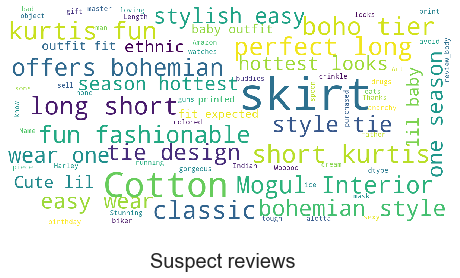

In [31]:
show_wordcloud(suspect_revs, 'Suspect reviews')

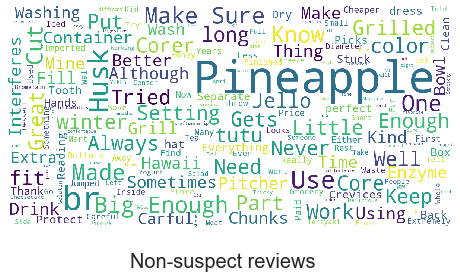

In [32]:
show_wordcloud(non_suspect_revs, 'Non-suspect reviews')

In [33]:
df_copy = url_df.copy()

In [34]:
len(df_copy)

5881874

In [35]:
# Drop rows with Nan's in review_body
df_copy.dropna(subset=['review_body'], inplace=True)
len(df_copy)

5881089

In [36]:
df_copy.columns

Index(['marketplace', 'customer_id', 'review_id', 'product_id',
       'product_parent', 'product_title', 'product_category', 'star_rating',
       'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
       'review_headline', 'review_body', 'review_date', 'suspect'],
      dtype='object')

In [37]:
# Create features and targets
X_reviews = df_copy[['review_body', 'customer_id']]
y = df_copy.suspect

In [38]:
# Features + target
X_all = df_copy[['review_body', 'customer_id', 'star_rating', 'helpful_votes', 'vine', 'verified_purchase', 'suspect']].copy()
X_all.tail()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,suspect
5881869,Ok,41086556,5.0,0.0,N,Y,0
5881870,Purchased and wore these tutus for the Portland to Coast relay race. The were a one size fits all although we cut off about 12 or more inches as they were too long for our needs. Soft and not at all scratchy.,20641436,5.0,12.0,N,Y,0
5881871,"Was kind of long but, had to trim it a bit to fit under my custom made tutu. The color was spot on :)",46003968,3.0,0.0,N,Y,0
5881872,What a spectacular tutu! Very slimming.,10988987,5.0,0.0,N,Y,0
5881873,"This is thick enough that you can't see through it, but it is very long, so be sure to check the dimensions. I ended up cutting it shorter.",47148712,4.0,0.0,N,Y,0


In [39]:
len(X_all)

5881089

In [40]:
len(X_all.customer_id.unique())

3218612

### Create cosine similarity feature for all reviews

In [41]:
# Create cosine similarity column, fill with 0
X_all.loc[:,'cosine_sim'] = 0
X_all.tail(3)

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,suspect,cosine_sim
5881871,"Was kind of long but, had to trim it a bit to fit under my custom made tutu. The color was spot on :)",46003968,3.0,0.0,N,Y,0,0
5881872,What a spectacular tutu! Very slimming.,10988987,5.0,0.0,N,Y,0,0
5881873,"This is thick enough that you can't see through it, but it is very long, so be sure to check the dimensions. I ended up cutting it shorter.",47148712,4.0,0.0,N,Y,0,0


In [42]:
def tokenizer(x):
    """Tokenizer for X_all dataframe, will tokenize punctuations and :) """
    r='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'
    to_replace=[re.escape(i) for i in r]
    replace_with=[' '+i+' ' for i in r]
    x=x.lower()
    x=pd.DataFrame([x])[0].replace(to_replace,replace_with,regex=True)[0]
    return(x)

def get_cossim_feature(df):
    """Function that adds cosine_sim feature column to dataframe df. Cosine similarity is computed for the reviews of 
    each unique customer ID. If only 1 review, does nothing; if 2 reviews, takes the cosine similarity between reviews; if 
    more than 2, computes the mean of the best two similarity scores."""
    # Counter for the number of reviews skipped due to emojis
    emoji_n = 0    
    for c in df.customer_id.unique():
        #print(c)
        temp_revs = df[df.customer_id == c].review_body
        # Initiate best2 array
        best2 = np.array([])
        # If there are 2 reviews
        if len(temp_revs) == 2: 
            # Boolean check for emoji in text
            rev1 = temp_revs.iloc[0]
            rev2 = temp_revs.iloc[1]
            # Break, if both reviews have emojis
            if bool(emoji.get_emoji_regexp().search(rev1) and 
                    emoji.get_emoji_regexp().search(rev2)) == True:
                emoji_n += 2
                print('Emoji reviews skipped:', emoji_n)
                continue
            # Instantiate tfidf vectorizer
            tfidf = TfidfVectorizer(tokenizer=tokenizer)
            vec = tfidf.fit_transform(temp_revs)
            # Create cosine matrix
            cosine_matrix = cosine_similarity(vec, vec)
            cossim = np.around(cosine_matrix[0][1], decimals=2)
            df.loc[temp_revs.index, 'cosine_sim'] = cossim  
        # If there are more than 2 reviews
        elif len(temp_revs) > 2: 
            if bool(emoji.get_emoji_regexp().search(temp_revs.iloc[0]) and
                emoji.get_emoji_regexp().search(temp_revs.iloc[1])) == True:
                emoji_n += 2
                print('Emoji reviews skipped:', emoji_n)
                continue
            # Instantiate tfidf vectorizer
            tfidf = TfidfVectorizer(tokenizer=tokenizer)
            #tfidf = TfidfVectorizer(tokenizer=tokenize_lem, token_pattern='(?u)\b\w\w+\b')
            vec = tfidf.fit_transform(temp_revs)
            # Create cosine matrix
            cosine_matrix = cosine_similarity(vec, vec)
            n = len(cosine_matrix)          
            for ind in range(len(cosine_matrix)):
                if ind < n-2:
                    arr = cosine_matrix[ind][ind+1:n+1]
                    # Indices of maximum two values in array
                    inds = np.argsort(arr)[-2:]
                    # Maximum cosine similarities in array
                    top2 = arr[inds]
                    # Record the best 2 of the first array
                    if best2.size == 0:
                        best2 = top2
                    # If both scores are 1.0, record and continue next review
                    if best2[0] == 1 and best2[1] ==1:
                        continue
                    # Add cosine similarity if it is larger than either of the best2
                    elif top2[0] > best2[0] or top2[0] > best2[1]:
                        best2 = np.append(best2, top2[0])
                        max_inds = np.argsort(best2)[-2:]
                        best2 = best2[max_inds]
                    elif top2[1] > best2[0] or top2[1] > best2[1]:
                        best2 = np.append(best2, top2[1])
                        max_inds = np.argsort(best2)[-2:]
                        best2 = best2[max_inds]
            cossim = np.around(np.mean(best2), decimals=2)
            df.loc[temp_revs.index, 'cosine_sim'] = cossim
        

In [43]:
X_all.tail()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,suspect,cosine_sim
5881869,Ok,41086556,5.0,0.0,N,Y,0,0
5881870,Purchased and wore these tutus for the Portland to Coast relay race. The were a one size fits all although we cut off about 12 or more inches as they were too long for our needs. Soft and not at all scratchy.,20641436,5.0,12.0,N,Y,0,0
5881871,"Was kind of long but, had to trim it a bit to fit under my custom made tutu. The color was spot on :)",46003968,3.0,0.0,N,Y,0,0
5881872,What a spectacular tutu! Very slimming.,10988987,5.0,0.0,N,Y,0,0
5881873,"This is thick enough that you can't see through it, but it is very long, so be sure to check the dimensions. I ended up cutting it shorter.",47148712,4.0,0.0,N,Y,0,0


## Splitting the data

In [44]:
# Split the suspects
# p=percentage of suspicious reviewers for training set
p = 0.6
train_n = round(len(suspects30)*p)
# Set seed and shuffle suspects list
random.Random(48).shuffle(suspects30)
print('Number of suspects in training = {}'.format(train_n))
print('Number of suspects for testing and hold out set = {}'.format(len(suspects30)-train_n))
print('Number of suspects total = {}'.format(len(suspects30)))

Number of suspects in training = 161
Number of suspects for testing and hold out set = 107
Number of suspects total = 268


In [45]:
split2 = round((len(suspects30)-train_n)/2)
split2

54

In [46]:
# Split suspects into train and test sets
suspects_train = suspects30[:train_n]
suspects_other = suspects30[train_n:]
suspects_test = suspects_other[:split2]
suspects_hold = suspects_other[split2:]
# Print number of suspects in training and test sets
print('Number of suspects in training set:', len(suspects_train))
print(suspects_train[:5])
print('Number of suspects in test set:',len(suspects_test))
print(suspects_test[:5])
print('Number of suspects in hold out set:',len(suspects_hold))

Number of suspects in training set: 161
[49857685, 28232486, 1887243, 4702550, 21873089]
Number of suspects in test set: 54
[31238085, 40329126, 8862395, 2110663, 34006808]
Number of suspects in hold out set: 53


In [47]:
# Separate the predictors and target in training set
X_train_suspect = X_all[X_all['customer_id'].isin(suspects_train)].drop(['suspect'], axis=1)
y_train_suspect = X_all[X_all['customer_id'].isin(suspects_train)].suspect
train_n = len(X_train_suspect)

print('There are {} reviews written by "suspects" in the training dataset'.format(train_n))

There are 8928 reviews written by "suspects" in the training dataset


In [48]:
# Separate the predictors and target in testing set
X_test_suspect = X_all[X_all['customer_id'].isin(suspects_test)].drop(['suspect'], axis=1)
y_test_suspect = X_all[X_all['customer_id'].isin(suspects_test)].suspect

print('There are {} reviews written by "suspects" in the testing dataset'.format(len(X_test_suspect)))

There are 3389 reviews written by "suspects" in the testing dataset


In [49]:
# Separate the predictors and target in hold out set
X_hold_suspect = X_all[X_all['customer_id'].isin(suspects_hold)].drop(['suspect'], axis=1)
y_hold_suspect = X_all[X_all['customer_id'].isin(suspects_hold)].suspect

print('There are {} reviews written by "suspects" in the hold out dataset'.format(len(X_hold_suspect)))

There are 3043 reviews written by "suspects" in the hold out dataset


In [50]:
X_train_suspect.head(3)

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim
19445,Nice,17113841,5.0,4.0,N,Y,0
27689,"This outfit is not at all what it looked like on the pic, it's no surprise why the pic no longer available.very off on color as well as the fitting. I waited a few wks for this item only to be disappointed.I wish I could give no stars.",11246616,1.0,0.0,N,Y,0
29674,Perfect for any body type very flattering !!⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️,11246616,5.0,0.0,N,Y,0


In [51]:
# Select columns from non_suspect dataframe
non_suspect = non_suspect[['review_body', 'customer_id', 'star_rating', 'helpful_votes', 'vine', 
                           'verified_purchase', 'suspect']]

In [52]:
# Remove the rows that does not contain a review in 'review_body'
non_suspect.dropna(subset=['review_body'], inplace=True)
print('The total number of non-suspect reviews = {}'.format(len(non_suspect)))

The total number of non-suspect reviews = 5865729


In [53]:
# Add cosine_sim feature column
non_suspect.loc[:,'cosine_sim'] = 0

non_suspect.tail(3)

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,suspect,cosine_sim
5881871,"Was kind of long but, had to trim it a bit to fit under my custom made tutu. The color was spot on :)",46003968,3.0,0.0,N,Y,0,0
5881872,What a spectacular tutu! Very slimming.,10988987,5.0,0.0,N,Y,0,0
5881873,"This is thick enough that you can't see through it, but it is very long, so be sure to check the dimensions. I ended up cutting it shorter.",47148712,4.0,0.0,N,Y,0,0


In [54]:
# Split the non-suspect data: 60% train, 40% other
X_train_non, X_other, y_train_non, y_other = train_test_split(non_suspect.drop(['suspect'], axis=1), 
                                                                    non_suspect['suspect'], test_size=0.4, 
                                                                    random_state = 0)

In [55]:
# Split the non-suspect data: 50% test, 50% hold out
X_test_non, X_hold_non, y_test_non, y_hold_non = train_test_split(X_other, y_other, test_size=0.5, random_state = 0)

In [56]:
# View non-suspect training and test dataset sizes
print(X_train_non.shape)
print(X_test_non.shape)
print(X_hold_non.shape)

(3519437, 7)
(1173146, 7)
(1173146, 7)


In [57]:
# Create balanced training set - same number of reviews from suspect and non-suspect groups

# Concatenate the training sets, and use the same amount of reviews from non-suspect reviews
X_train_bal = pd.concat([X_train_suspect, X_train_non.iloc[0:train_n]], ignore_index=True)
y_train_bal = pd.concat([y_train_suspect, y_train_non.iloc[0:train_n]], ignore_index=True)

# Concatenate the test sets
X_test = pd.concat([X_test_suspect, X_test_non], ignore_index=True)
y_test = pd.concat([y_test_suspect, y_test_non], ignore_index=True)

# Concatenate the hold out sets
X_hold = pd.concat([X_hold_suspect, X_hold_non], ignore_index=True)
y_hold = pd.concat([y_hold_suspect, y_hold_non], ignore_index=True)

In [58]:
print(len(X_train_bal))
print(len(X_test))
print(len(X_hold))
print(len(X_train_bal) + len(X_test))

17856
1176535
1176189
1194391


In [59]:
# Calculate the cosine similarities
get_cossim_feature(X_train_bal)
X_train_bal.head()

Emoji reviews skipped: 2


,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim
0,Nice,17113841,5.0,4.0,N,Y,1.0
1,"This outfit is not at all what it looked like on the pic, it's no surprise why the pic no longer available.very off on color as well as the fitting. I waited a few wks for this item only to be disappointed.I wish I could give no stars.",11246616,1.0,0.0,N,Y,1.0
2,Perfect for any body type very flattering !!⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️⭐️,11246616,5.0,0.0,N,Y,1.0
3,A wonderful product and my wife loved him .. also a good price,44271271,5.0,0.0,N,Y,1.0
4,i love the color.hope it fit for me. cant wait to recieve this beautiful dress,22423356,5.0,0.0,N,Y,1.0


In [60]:
%%time
# ~1.5 hours
get_cossim_feature(X_test)
X_test.head()

Emoji reviews skipped: 2
Emoji reviews skipped: 4
Emoji reviews skipped: 6
Emoji reviews skipped: 8
Emoji reviews skipped: 10
Emoji reviews skipped: 12
Emoji reviews skipped: 14
Emoji reviews skipped: 16
Emoji reviews skipped: 18
Emoji reviews skipped: 20
Emoji reviews skipped: 22
Emoji reviews skipped: 24
Emoji reviews skipped: 26
Emoji reviews skipped: 28
Emoji reviews skipped: 30
Emoji reviews skipped: 32
Emoji reviews skipped: 34
Emoji reviews skipped: 36
Emoji reviews skipped: 38
Emoji reviews skipped: 40
Emoji reviews skipped: 42
Emoji reviews skipped: 44
Emoji reviews skipped: 46
Emoji reviews skipped: 48
Emoji reviews skipped: 50
Emoji reviews skipped: 52
Emoji reviews skipped: 54
Emoji reviews skipped: 56
Emoji reviews skipped: 58
Emoji reviews skipped: 60
Emoji reviews skipped: 62
Emoji reviews skipped: 64
Emoji reviews skipped: 66
Emoji reviews skipped: 68
Emoji reviews skipped: 70
Emoji reviews skipped: 72
Emoji reviews skipped: 74
Emoji reviews skipped: 76
Emoji reviews sk

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim
0,Great clothing fit prefect will order again.,24437194,5.0,0.0,N,Y,1.0
1,Great coffee mug and a great artist! Check out more of his work here! http://marklewisart.com/en/,24887144,5.0,0.0,N,N,1.0
2,Great coffee mug and a great artist! Check out more of his work here! http://marklewisart.com/en/,24887144,5.0,0.0,N,N,1.0
3,Great coffee mug and a great artist! Check out more of his work here! http://marklewisart.com/en/,24887144,5.0,0.0,N,N,1.0
4,Great coffee mug and a great artist! Check out more of his work here! http://marklewisart.com/en/,24887144,5.0,0.0,N,N,1.0


In [61]:
%%time
# ~1.5 hours
get_cossim_feature(X_hold)
X_hold.head()

Emoji reviews skipped: 2
Emoji reviews skipped: 4
Emoji reviews skipped: 6
Emoji reviews skipped: 8
Emoji reviews skipped: 10
Emoji reviews skipped: 12
Emoji reviews skipped: 14
Emoji reviews skipped: 16
Emoji reviews skipped: 18
Emoji reviews skipped: 20
Emoji reviews skipped: 22
Emoji reviews skipped: 24
Emoji reviews skipped: 26
Emoji reviews skipped: 28
Emoji reviews skipped: 30
Emoji reviews skipped: 32
Emoji reviews skipped: 34
Emoji reviews skipped: 36
Emoji reviews skipped: 38
Emoji reviews skipped: 40
Emoji reviews skipped: 42
Emoji reviews skipped: 44
Emoji reviews skipped: 46
Emoji reviews skipped: 48
Emoji reviews skipped: 50
Emoji reviews skipped: 52
Emoji reviews skipped: 54
Emoji reviews skipped: 56
Emoji reviews skipped: 58
Emoji reviews skipped: 60
Emoji reviews skipped: 62
Emoji reviews skipped: 64
Emoji reviews skipped: 66
Emoji reviews skipped: 68
Emoji reviews skipped: 70
Emoji reviews skipped: 72
Emoji reviews skipped: 74
Emoji reviews skipped: 76
Emoji reviews sk

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim
0,Lovely quality👍,5653692,5.0,0.0,N,Y,1.0
1,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,0.0,N,N,1.0
2,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,0.0,N,N,1.0
3,SO CUTE AND I LOVE IT. ABSOLUTELY PERFECT,9968579,5.0,2.0,N,Y,1.0
4,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,7.0,N,N,1.0


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


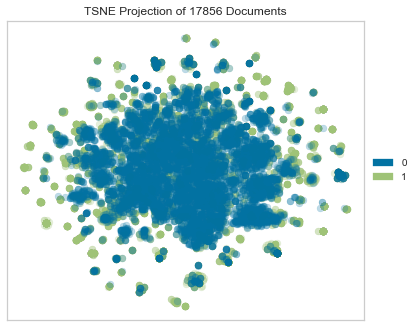

C:\Users\chant\Anaconda3\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


TSNEVisualizer(alpha=0.25,
               ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000240A57ADBC8>,
               classes=None, colormap=None, colors=None, decompose=None,
               decompose_by=None, labels=['non-suspect', 'suspect'],
               random_state=None)

In [62]:
# Visualize with TSNE = t-distributed stochastic neighbor embedding
tfidf = TfidfVectorizer(stop_words=stopwords_english, tokenizer=tokenize_lem, min_df=5)
X_transformed = tfidf.fit_transform(X_train_bal.review_body)
tsne(X_transformed, y_train_bal, labels=['non-suspect', 'suspect'], alpha=0.25)

## FeatureUnion transformers

In [63]:
# Custom transformers for pipelines
# https://github.com/jem1031/pandas-pipelines-custom-transformers
class ColExtractor(TransformerMixin):  
    def __init__(self, col):
        self.col = col # Extract column 'col'
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        Xcols = X[self.col]
        return Xcols

class DummyTransformer(TransformerMixin):

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum


## Text only model

In [64]:
def print_all_metrics(y_true, y_preds, pos_probs):
    # Print metrics
    precision, recall, _ = precision_recall_curve(y_true, pos_probs)
    auc_score = auc(recall, precision)
    print('PR AUC: %.5f' % auc_score)
    print('ROC AUC: {:.5f}'.format(roc_auc_score(y_true, pos_probs)))
    print('Recall: %.5f' % recall_score(y_true, y_preds))
    print('F2 Measure: %.5f' % fbeta_score(y_true, y_preds, beta=2.0))

In [65]:
%%time
# Pipeline for text only pre-processing
pipe1 = Pipeline([
    ('text_feats', Pipeline([
        ('selector', ColExtractor('review_body')),
        ('tfidf', TfidfVectorizer(stop_words=stopwords_english, tokenizer=tokenize_lem, min_df=5)), 
    ])),
])

# Train on balanced reviews
pipe1.fit(X_train_bal)
# Transform all X features
X_train_1 = pipe1.transform(X_train_bal)
X_test_1 = pipe1.transform(X_test)


C:\Users\chant\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 12min 1s


In [66]:
print(X_train_1.shape)
print(X_test_1.shape)

(17856, 2813)
(1176535, 2813)


In [67]:
# Fit Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_1, y_train_bal)
nb_ypreds = nb.predict(X_test_1)
# Positive class predictions
nb_pos_probs = nb.predict_proba(X_test_1)[:,1]

print_all_metrics(y_test, nb_ypreds, nb_pos_probs)

PR AUC: 0.01162
ROC AUC: 0.72594
Recall: 0.43671
F2 Measure: 0.03735


In [68]:
# Fit Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=123)
rf.fit(X_train_1, y_train_bal)
rf_ypreds = rf.predict(X_test_1)
# Positive class predictions
rf_pos_probs = rf.predict_proba(X_test_1)[:,1]

print_all_metrics(y_test, rf_ypreds, rf_pos_probs)

PR AUC: 0.01227
ROC AUC: 0.72333
Recall: 0.58100
F2 Measure: 0.02802


In [69]:
# Linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, C=1.0)
lsvc.fit(X_train_1, y_train_bal)
lsvc_ypreds = lsvc.predict(X_test_1)
lsvc_yprobs = lsvc.decision_function(X_test_1)

print_all_metrics(y_test, lsvc_ypreds, lsvc_yprobs)

PR AUC: 0.00962
ROC AUC: 0.69232
Recall: 0.46326
F2 Measure: 0.03414


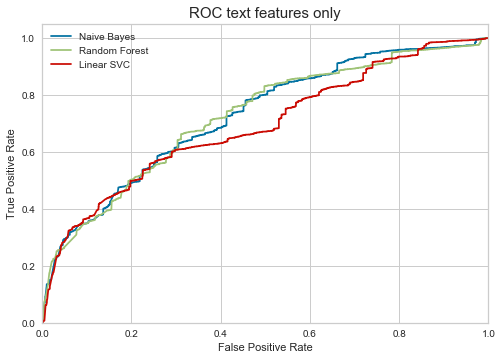

In [70]:
# Plot ROC curves - test set
all_probs = [nb_pos_probs, rf_pos_probs, lsvc_yprobs]
labels = ['Naive Bayes', 'Random Forest', 'Linear SVC']

plt.figure()
for x in range(len(all_probs)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, all_probs[x])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[1], tpr[1], label=labels[x])


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC text features only', fontsize=15)
plt.legend()
plt.show()

In [71]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, title):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65
    """
    plt.figure(figsize=(6,6))
    plt.title(title, fontsize=20)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score", fontsize=15)
    plt.xlabel("Decision Threshold", fontsize=15)
    plt.legend(loc='best', frameon=True, facecolor='white', framealpha=1, fontsize=15)

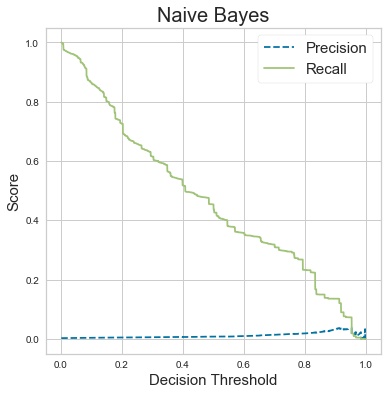

In [72]:
p,r,thresholds = precision_recall_curve(y_test, nb_pos_probs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Naive Bayes')

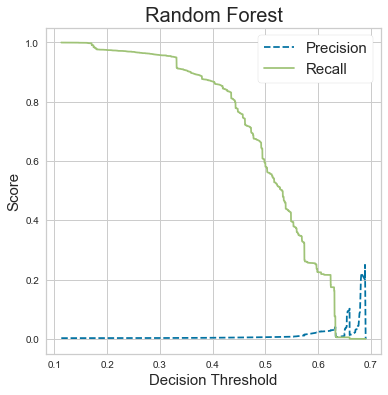

In [73]:
p,r,thresholds = precision_recall_curve(y_test, rf_pos_probs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Random Forest')

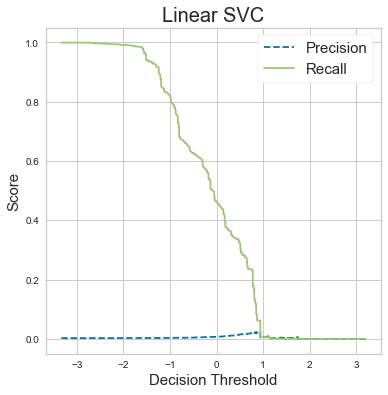

In [74]:
p,r,thresholds = precision_recall_curve(y_test, lsvc_yprobs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Linear SVC')

## Testing numerical and categorical feature model

In [75]:
# Pipeline for numerical and categorical feature pre-processing
NUM_FEATS = ['helpful_votes', 'cosine_sim']
CAT_FEATS = ['star_rating', 'vine', 'verified_purchase']

pipe2 = Pipeline([
    ('union', FeatureUnion([
        # Pipeline for numeric features
        ('num_feats', Pipeline([
            ('selector', ColExtractor(NUM_FEATS)),
            ('scaler', MinMaxScaler()),
        ])),
        # Pipeline for categorical features
        ('cat_feats', Pipeline([
            ('selector', ColExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer()),
        ])),   
    ])),      
])
# Train on balanced reviews
pipe2.fit(X_train_bal)
# Transform all X features
X_train_2 = pipe2.transform(X_train_bal)
X_test_2 = pipe2.transform(X_test)
X_hold_2 = pipe2.transform(X_hold)

In [76]:
print(X_train_2.shape)
print(X_test_2.shape)

(17856, 6)
(1176535, 6)


In [77]:
# Multinomial Naive Bayes
# Fit Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_2, y_train_bal)
nb_ypreds = nb.predict(X_test_2)
# Positive class predictions
nb_pos_probs = nb.predict_proba(X_test_2)[:,1]

print_all_metrics(y_test, nb_ypreds, nb_pos_probs)

PR AUC: 0.30012
ROC AUC: 0.97516
Recall: 1.00000
F2 Measure: 0.04279


In [78]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=123)
rf.fit(X_train_2, y_train_bal)
rf_ypreds = rf.predict(X_test_2)
# Positive class predictions
rf_pos_probs = rf.predict_proba(X_test_2)[:,1]

print_all_metrics(y_test, rf_ypreds, rf_pos_probs)

PR AUC: 0.29091
ROC AUC: 0.98043
Recall: 0.99823
F2 Measure: 0.08681


In [79]:
# Linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, C=1.0)
lsvc.fit(X_train_2, y_train_bal)
lsvc_ypreds = lsvc.predict(X_test_2)
lsvc_yprobs = lsvc.decision_function(X_test_2)

print_all_metrics(y_test, lsvc_ypreds, lsvc_yprobs)

PR AUC: 0.17563
ROC AUC: 0.98710
Recall: 1.00000
F2 Measure: 0.04408


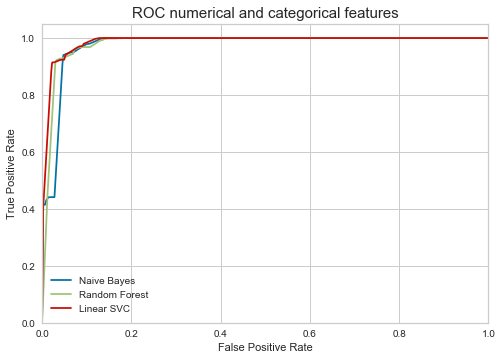

In [80]:
# Plot ROC curves - test set
all_probs = [nb_pos_probs, rf_pos_probs, lsvc_yprobs]
labels = ['Naive Bayes', 'Random Forest', 'Linear SVC']

plt.figure()
for x in range(len(all_probs)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, all_probs[x])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[1], tpr[1], label=labels[x])


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC numerical and categorical features', fontsize=15)
plt.legend()
plt.show()

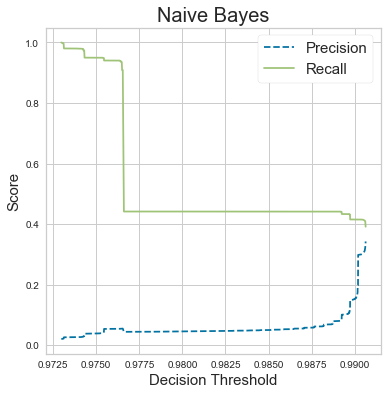

In [81]:
p,r,thresholds = precision_recall_curve(y_test, nb_pos_probs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Naive Bayes')

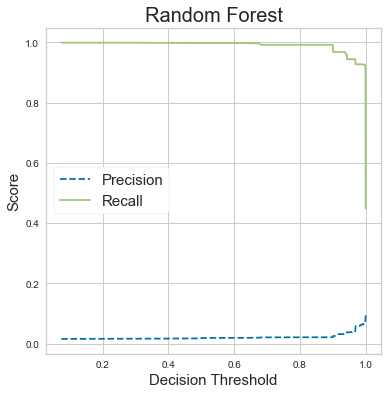

In [82]:
p,r,thresholds = precision_recall_curve(y_test, rf_pos_probs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Random Forest')

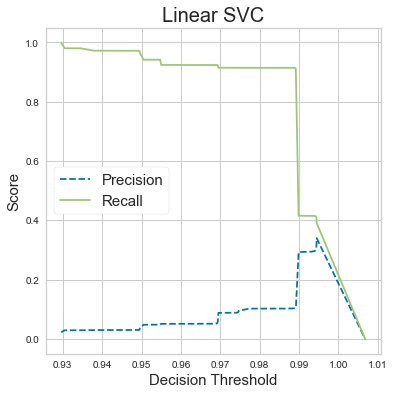

In [83]:
p,r,thresholds = precision_recall_curve(y_test, lsvc_yprobs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Linear SVC')

## Combining all features: numeric, categorical and text

In [84]:
# Pipeline for pre-processing all columns

NUM_FEATS = ['helpful_votes', 'cosine_sim']
CAT_FEATS = ['star_rating', 'vine', 'verified_purchase']

pipeline = Pipeline([
    ('union', FeatureUnion([
        # Pipeline for numeric features
        ('num_feats', Pipeline([
            ('selector', ColExtractor(NUM_FEATS)),
            ('scaler', MinMaxScaler()),
        ])),
        # Pipeline for categorical features
        ('cat_feats', Pipeline([
            ('selector', ColExtractor(CAT_FEATS)),
            ('dummy', DummyTransformer()),
        ])),
        # Pipeline for text
        ('text_feats', Pipeline([
            ('selector', ColExtractor('review_body')),
            ('tfidf', TfidfVectorizer(stop_words=stopwords_english, tokenizer=tokenize_lem, min_df=5)), 
        ])),
    ])),       
])


In [85]:
%%time
# Train on balanced reviews
pipeline.fit(X_train_bal)
# Transform all X features
X_train_3 = pipeline.transform(X_train_bal)
X_test_3 = pipeline.transform(X_test)
X_hold_3 = pipeline.transform(X_hold)

C:\Users\chant\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Wall time: 27min 39s


In [86]:
print(X_train_3.shape)
print(X_test_3.shape)
print(X_hold_3.shape)

(17856, 2819)
(1176535, 2819)
(1176189, 2819)


In [87]:
# Fit Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_3, y_train_bal)
nb_ypreds = nb.predict(X_test_3)

# Get probability predictions for each class in test set
nb_probs = nb.predict_proba(X_test_3)
# Probabilities for suspect (class 1)
nb_pos_probs = nb_probs[:,1]

# Print metrics
print_all_metrics(y_test, nb_ypreds, nb_pos_probs)

PR AUC: 0.04758
ROC AUC: 0.92831
Recall: 0.96194
F2 Measure: 0.04202


In [88]:
# Fit Random Forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=123)
rf.fit(X_train_3, y_train_bal)
rf_ypreds = rf.predict(X_test_3)

# Predict probability of classes
rf_probs = rf.predict_proba(X_test_3)
# Retrieve just the probabilities for suspect class (class 1)
rf_pos_probs = rf_probs[:, 1]
# Print all metrics
print_all_metrics(y_test, rf_ypreds, rf_pos_probs)

PR AUC: 0.08501
ROC AUC: 0.95988
Recall: 0.92918
F2 Measure: 0.14235


In [89]:
# Linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, C=1.0)
# Fit model to training set
lsvc.fit(X_train_3, y_train_bal)
# Class 1 predictions on test set
lsvc_ypreds = lsvc.predict(X_test_3)
# Class 1 probabilities on test set
lsvc_yprobs = lsvc.decision_function(X_test_3)
# Print all metrics
print_all_metrics(y_test, lsvc_ypreds, lsvc_yprobs)

PR AUC: 0.04894
ROC AUC: 0.94718
Recall: 1.00000
F2 Measure: 0.04420


In [90]:
# Print ROC scores - test set
print(roc_auc_score(y_test, nb_pos_probs))
print(roc_auc_score(y_test, rf_pos_probs))
print(roc_auc_score(y_test, lsvc_yprobs))

0.9283097255167785
0.9598780551736307
0.9471812783765708


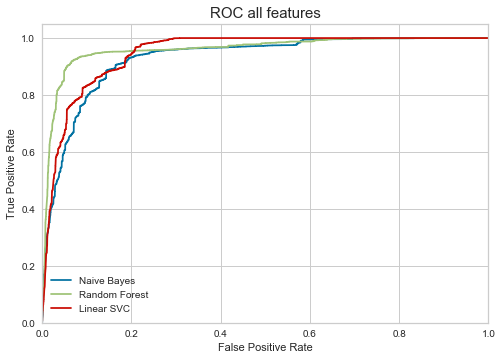

In [91]:
# Plot ROC curves - test set
all_probs = [nb_pos_probs, rf_pos_probs, lsvc_yprobs]
labels = ['Naive Bayes', 'Random Forest', 'Linear SVC']

plt.figure()
for x in range(len(all_probs)):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, all_probs[x])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[1], tpr[1], label=labels[x])


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC all features', fontsize=15)
plt.legend()
plt.show()

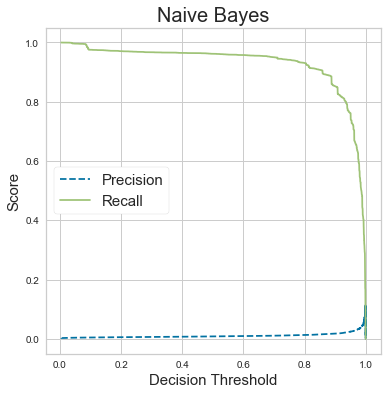

In [92]:
p,r,thresholds = precision_recall_curve(y_test, nb_pos_probs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Naive Bayes')

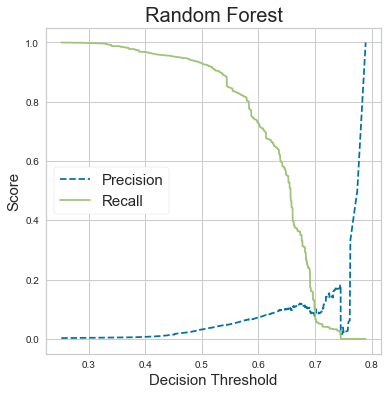

In [93]:
p,r,thresholds = precision_recall_curve(y_test, rf_pos_probs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Random Forest')

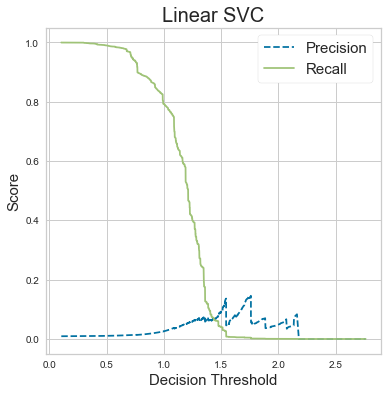

In [94]:
p,r,thresholds = precision_recall_curve(y_test, lsvc_yprobs)
plot_precision_recall_vs_threshold(p,r,thresholds, 'Linear SVC')

### Tuning for max F2 measure

In [95]:
def to_labels(pos_probs, threshold):
    """Create classification labels on custom threshold"""
    new_labels = (pos_probs >= threshold).astype(int)
    return new_labels

#### Hyperparameter tuning for Multinomial Naive Bayes, numerical and categorical features

In [96]:
# defining parameter range 
param_grid = {'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}

grid = GridSearchCV(MultinomialNB(), param_grid) 

# fitting the model for grid search 
grid.fit(X_train_2, y_train_bal) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 


{'alpha': 1}
MultinomialNB(alpha=1, class_prior=None, fit_prior=True)


In [97]:
%%time
# Tune threshold for max F2 score: Naive Bayes
# Fit Multinomial Naive Bayes classifier
nb = MultinomialNB()
nb.fit(X_train_2, y_train_bal)

# Get probability predictions for each class in test set
nb_probs = nb.predict_proba(X_test_2)
# Probabilities for suspect (class 1)
nb_pos_probs = nb_probs[:,1]

# Define thresholds
thresholds = np.arange(0, 1, 0.001)
# Evaluate each threshold
scores = [fbeta_score(y_test, to_labels(nb_pos_probs, t), beta=2.0) for t in thresholds]
# Get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F2-Score=%.5f' % (thresholds[ix], scores[ix]))

nb_threshold = thresholds[ix]

Threshold=0.990, F2-Score=0.30914
Wall time: 7min 59s


In [98]:
# Use new threshold on hold out set
nb_probs = nb.predict_proba(X_hold_2)
# Probabilities for suspect (class 1)
nb_pos_probs = nb_probs[:,1]
# Predict class using custom threshold
nb_predicted_a = to_labels(nb_pos_probs, nb_threshold)

# Print metrics
print('Threshold = %.5f' % nb_threshold)
print_all_metrics(y_hold, nb_predicted_a, nb_pos_probs)


Threshold = 0.99000
PR AUC: 0.06745
ROC AUC: 0.96428
Recall: 0.15577
F2 Measure: 0.11616


In [99]:
print(confusion_matrix(y_hold, nb_predicted_a))
print('Precision: %.5f' % precision_score(y_hold, nb_predicted_a))

[[1165389    7757]
 [   2569     474]]
Precision: 0.05759


#### Hyperparameter tuning for Linear SVC, numerical and categorical features

In [100]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10, 100]}

grid = GridSearchCV(LinearSVC(penalty='l2', dual=False), param_grid) 

# fitting the model for grid search 
grid.fit(X_train_2, y_train_bal) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 0.1}
LinearSVC(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)


In [101]:
# Linear SVC
lsvc = LinearSVC(penalty='l2', dual=False, C=0.1)
# Fit model to training set
lsvc.fit(X_train_2, y_train_bal)
# Class 1 probabilities on test set
lsvc_yprobs = lsvc.decision_function(X_test_2)

# Define thresholds
thresholds = np.arange(-1, 1, 0.01)
# Evaluate each threshold
scores = [fbeta_score(y_test, to_labels(lsvc_yprobs, t), beta=2.0) for t in thresholds]
# Get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F2-Score=%.5f' % (thresholds[ix], scores[ix]))

lsvc_threshold = thresholds[ix]

Threshold=0.990, F2-Score=0.37864


In [102]:
# Use new threshold on hold out set
lsvc_yprobs = lsvc.decision_function(X_hold_2)

# Predict class using custom threshold
lsvc_predicted = to_labels(lsvc_yprobs, lsvc_threshold)

# Print metrics
print('Threshold = %.5f' % lsvc_threshold)
print_all_metrics(y_hold, lsvc_predicted, lsvc_yprobs)

Threshold = 0.99000
PR AUC: 0.07131
ROC AUC: 0.98212
Recall: 0.07295
F2 Measure: 0.06940


In [103]:
print(confusion_matrix(y_hold, lsvc_predicted))
print('Precision: %.5f' % precision_score(y_hold, lsvc_predicted))

[[1169545    3601]
 [   2821     222]]
Precision: 0.05807


#### Hyperparameter tuning for Random Forest, numerical and categorical features

In [104]:
# Gridsearch CV
# defining parameter range 
param_grid = {'n_estimators': [10, 100, 200, 300],
             'max_depth': [10, 20, 30]}

grid = GridSearchCV(RandomForestClassifier(random_state=123), param_grid, refit = True) 

# fitting the model for grid search 
grid.fit(X_train_2, y_train_bal) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'max_depth': 10, 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


In [105]:
# Tune threshold for max F2 score: Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=123)
rf.fit(X_train_2, y_train_bal)

# Predict probability of classes
rf_probs = rf.predict_proba(X_test_2)
# Retrieve just the probabilities for suspect class (class 1)
rf_pos_probs = rf_probs[:, 1]

# Define thresholds
thresholds = np.arange(0, 1, 0.001)
# Evaluate each threshold
scores = [fbeta_score(y_test, to_labels(rf_pos_probs, t), beta=2.0) for t in thresholds]
# Get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F2-Score=%.5f' % (thresholds[ix], scores[ix]))

rf_threshold = thresholds[ix]
print(rf_threshold)

Threshold=0.999, F2-Score=0.28717
0.999


In [106]:
# Use new threshold on hold out set: Random Forest
rf_probs = rf.predict_proba(X_hold_2)
# Probabilities for suspect (class 1)
rf_pos_probs = rf_probs[:,1]
# Predict class using custom threshold
rf_predicted_a = to_labels(rf_pos_probs, rf_threshold)
# Print all metrics
print('Threshold = %.5f' % rf_threshold)
print_all_metrics(y_hold, rf_predicted_a, rf_pos_probs)


Threshold = 0.99900
PR AUC: 0.10695
ROC AUC: 0.96557
Recall: 0.86198
F2 Measure: 0.25045


#### Hyperparameter tuning Random Forest, all features

In [107]:
# Gridsearch CV
# defining parameter range 
param_grid = {'n_estimators': [10, 100, 200, 300],
             'max_depth': [10, 20, 30]}

grid = GridSearchCV(RandomForestClassifier(random_state=123), param_grid, refit = True) 

# fitting the model for grid search 
grid.fit(X_train_3, y_train_bal) 

# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'max_depth': 30, 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)


In [108]:
# Tune threshold for max F2 score: Random Forest
rf = RandomForestClassifier(n_estimators=200, max_depth=30, random_state=123)
rf.fit(X_train_3, y_train_bal)

# Predict probability of classes
rf_probs = rf.predict_proba(X_test_3)
# Retrieve just the probabilities for suspect class (class 1)
rf_pos_probs = rf_probs[:, 1]

# Define thresholds
thresholds = np.arange(0, 1, 0.001)
# Evaluate each threshold
scores = [fbeta_score(y_test, to_labels(rf_pos_probs, t), beta=2.0) for t in thresholds]
# Get best threshold
ix = np.argmax(scores)
print('Threshold=%.3f, F2-Score=%.5f' % (thresholds[ix], scores[ix]))

rf_threshold = thresholds[ix]
print(rf_threshold)

Threshold=0.746, F2-Score=0.28840
0.746


In [109]:
# Use new threshold on hold out set: Random Forest
rf_probs = rf.predict_proba(X_hold_3)
# Probabilities for suspect (class 1)
rf_pos_probs = rf_probs[:,1]
# Predict class using custom threshold
rf_predicted_a = to_labels(rf_pos_probs, rf_threshold)
# Print all metrics
print('Threshold = %.5f' % rf_threshold)
print_all_metrics(y_hold, rf_predicted_a, rf_pos_probs)


Threshold = 0.74600
PR AUC: 0.07518
ROC AUC: 0.97446
Recall: 0.65823
F2 Measure: 0.28349


In [110]:
print(confusion_matrix(y_hold, rf_predicted_a))
print('Precision: %.5f' % precision_score(y_hold, rf_predicted_a))

[[1151994   21152]
 [   1040    2003]]
Precision: 0.08650


Text(0, 0.5, 'Probability of suspect class')

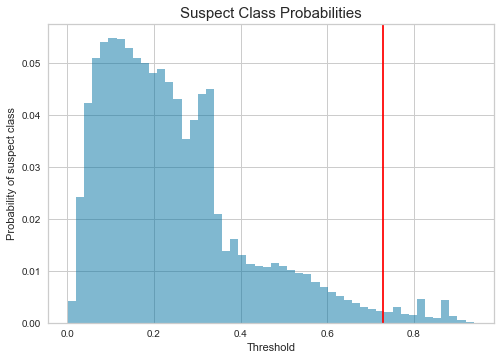

In [111]:
# Adjust weights for histograms to make PDF, area under the curve = 1
weights = np.ones_like(rf_pos_probs) / len(rf_pos_probs)
# Keyword arguments for histograms
kwargs = dict(histtype='stepfilled', bins=50, alpha=0.5)

plt.hist(rf_pos_probs, weights=weights, label='Random Forest', **kwargs)
plt.axvline(x=0.728, color='red')

plt.title('Suspect Class Probabilities', fontsize=15)
plt.xlabel('Threshold')
plt.ylabel('Probability of suspect class')
#plt.legend(frameon=True, facecolor='white', framealpha=1)

Text(0, 0.5, 'Proportion of data')

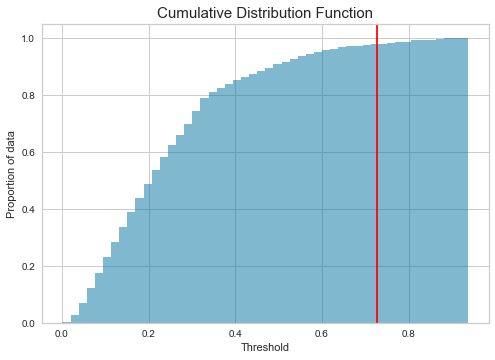

In [112]:
kwargs = dict(histtype='stepfilled', bins=50, cumulative=True, density=True, alpha=0.5)
plt.hist(rf_pos_probs, label='Random Forest', **kwargs)
plt.axvline(x=0.728, color='red')
plt.title('Cumulative Distribution Function', fontsize=15)
plt.xlabel('Threshold')
plt.ylabel('Proportion of data')

### False Positives and False Negative Reviews

Check out Random Forest false positive reviews

In [113]:
# False positives - are these suspicious?
condition = (y_hold == 0) & (rf_predicted_a == 1)
fp = X_hold[condition]
actual = pd.DataFrame(y_hold[condition])
predicted = pd.DataFrame(rf_predicted_a[condition], index=fp.index, columns=['predicted'])
pd.concat([fp, actual, predicted], axis=1).head()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim,suspect,predicted
3099,Too complicated to return,48043237,1.0,0.0,N,Y,1.0,0,1
3134,loveit,337699,5.0,1.0,N,Y,1.0,0,1
3215,This product is very good. It everything that i expected and I do not have any regret. I recomended it.,2366235,5.0,0.0,N,Y,1.0,0,1
3289,Good,1258612,5.0,0.0,N,Y,1.0,0,1
3314,Excellent product,10923337,5.0,0.0,N,Y,1.0,0,1


In [114]:
pd.concat([fp, actual, predicted], axis=1).tail()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim,suspect,predicted
1175987,good,37232446,3.0,0.0,N,Y,1.00,0,1
1176044,Perfect as Described !!!!!,4561274,5.0,0.0,N,Y,1.00,0,1
1176050,"Everything's perfect, thanks!",14563705,5.0,0.0,N,Y,1.00,0,1
1176133,"As expected. No problems, but nothing particularly special about them either.",13401648,4.0,0.0,N,Y,0.99,0,1
1176185,Nice,5107356,5.0,0.0,N,Y,1.00,0,1


The reviews from the false positives are very short and generic. It is hard to say whether or not these reviews are truly suspicious.

Random Forest false negatives

In [115]:
# False negatives - model missed these
condition = (y_hold == 1) & (rf_predicted_a == 0)
fp = X_hold[condition]
actual = pd.DataFrame(y_hold[condition])
predicted = pd.DataFrame(rf_predicted_a[condition], index=fp.index, columns=['predicted'])
pd.concat([fp, actual, predicted], axis=1).head()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim,suspect,predicted
1,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,0.0,N,N,1.0,1,0
2,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,0.0,N,N,1.0,1,0
3,SO CUTE AND I LOVE IT. ABSOLUTELY PERFECT,9968579,5.0,2.0,N,Y,1.0,1,0
4,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,7.0,N,N,1.0,1,0
9,"Absolutely rude seller. Like other third party sellers on this website, sheinside provides a picture of a beautiful product but unlike other sellers, sheinside will give you a product that looks ABSOLUTELY nothing like the picture, and they will refuse to send a prepaid shipping label, which in turn leaves you unable to get a refund, unless you are willing to pay for a damn label to just return a horrible product and get your refund.. (which is absolutely ridiculous because they are basically making you pay, to get you money back.) STAY AWAY. I have linked my experience with them regarding another product.<br /><br />http://www.amazon.com/gp/product/B00UFBV4TU?psc=1&redirect=true&ref_=oh_aui_detailpage_o09_s00",9968579,1.0,5.0,N,N,1.0,1,0


One of the 'suspects' has copy and pasted bad review of seller to warn others about bad service and product.

In [116]:
pd.concat([fp, actual, predicted], axis=1).tail()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim,suspect,predicted
3026,"These are probably my favorite pair of stockings right now, which is saying something because I do have a LOT.",15483503,5.0,0.0,N,Y,1.00,1,0
3029,as described fit well...just a little long.,4994000,4.0,0.0,N,Y,0.98,1,0
3036,Good fit. My wife loves it. I got it as a gift just because. It fits perfect very comfortable Looks great on her,18711464,5.0,0.0,N,Y,1.00,1,0
3038,"Love my umbrella hat and all the compliments on it, but the band that fits around your head is basically glued to the metal part of the umbrella which keeps the umbrella part up, and it hurts really bad after a while. If you don't think you will be wearing this item for long periods of time and dont care much for your hair if you are a girl, then this item will be absolutely 5 stars.",9968579,3.0,0.0,N,Y,1.00,1,0
3042,This wig was perfect. it looks great and had a great price to match. Great for any male pirate costume or could be a females as well.,15293315,5.0,0.0,N,Y,1.00,1,0


Multinomial Naive Bayes false positives

In [118]:
# False positives - are these suspicious?
condition = (y_test == 0) & (nb_ypreds == 1)
fp = X_test[condition]
actual = pd.DataFrame(y_test[condition])
predicted = pd.DataFrame(nb_ypreds[condition], index=fp.index, columns=['predicted'])
pd.concat([fp, actual, predicted], axis=1).tail()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim,suspect,predicted
1176526,This was not as thick as it looks on the picture but its still has a nice look about it,16145714,4.0,0.0,N,Y,0.98,0,1
1176527,"I understand that they are suppose to be tight, but wow. For how tight they are, they are comfortable.",13972167,3.0,0.0,N,Y,0.82,0,1
1176530,This shirt has to be ironed after every wash. It becomes misshapen after just a few washes and just looks sloppy.,11487991,2.0,1.0,N,Y,0.85,0,1
1176532,"I've been rather satisfied with Columbia's T-shirts. These are comfortable, warm, they don't bind and feel good against the skin. There's nothing that I've seen about them that causes me to think otherwise.",5291529,5.0,1.0,N,N,0.99,0,1
1176534,"A Very well made cape it is very large and so it drags on the ground for my 14 year old, but it very well made and has beautiful blue sateen liner.",21360180,4.0,1.0,N,Y,0.96,0,1


Multinomial Naive Bayes false negatives

In [119]:
# False negatives - model missed these
condition = (y_test == 1) & (nb_ypreds == 0)
fp = X_test[condition]
actual = pd.DataFrame(y_test[condition])
predicted = pd.DataFrame(nb_ypreds[condition], index=fp.index, columns=['predicted'])
pd.concat([fp, actual, predicted], axis=1).tail()

,review_body,customer_id,star_rating,helpful_votes,vine,verified_purchase,cosine_sim,suspect,predicted
2164,"I like the fit even though it is slightly too big. It is great with straight leg or skinny jeans (falls below the butt). I only ordered an XL because it was &#34;juniors&#34; size. I normally wear a medium and that size would have probably worked well - just a shorter, closer fit. I ordered another one in purple and it is also fabulous! By the time I went back to get another color it seems that they were sold out!<br />I hope it become available in the white again...",19672530,5.0,0.0,N,Y,1.00,1,0
2171,This skirt is very nice. The price was amazing. I love the fit and design. The back ruffle is a great touch. The fabric has a bit if stretch but does not seem to stretch out of shape with wear. It has almost a tailored look to it. My regular size is a 9 juniors or 6-8 women's and this fits perfectly in a 9. The belt is not good quality but it will do... I can always change to a different belt. Overall - great purchase and delivered as expected.,19672530,5.0,0.0,N,Y,1.00,1,0
2235,I prefer more of a kimono sleeve on robes. I really wanted this because of the length but the sleeves take away from it.,10803049,2.0,1.0,N,Y,0.99,1,0
2876,Controls well and smooths nicely (especially the back). It is long enough to fit below pants waist level so it does not ride up. It rolls up while you take it off but that's no big deal. Thinking of ordering a black one.,19672530,5.0,0.0,N,Y,1.00,1,0
2921,"This robe is super cozy, soft and warm. I love that it actually goes to floor length (but doesn't drag) and the hood is big enough to still put over towel-wrapped wet hair. Perfect for after bath, shower or hot tub. Hubby and love to lounge around in these. I'm only afraid that we might not be able to keep the white so white. Only time will tell...<br />May have to order another color so I can rotate... LOL",19672530,5.0,1.0,N,Y,1.00,1,0
